<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer


from sklearn.model_selection import train_test_split, TimeSeriesSplit , GridSearchCV
from sklearn.pipeline import Pipeline

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor

import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
class taxi_ml():
    
    def __init__(self, df:pd.DataFrame) -> None:
        assert type(df) == pd.core.frame.DataFrame, 'Экземпляр класса должен иметь тип pd.DataFrame'

        try:
            self.data = df
        except:
            print('Не получилось создать экземляр класса')
            
        self.models_dict = {}

    
    @classmethod
    def instance_from_link(cls,link):
        return taxi_ml(
            df=pd.read_csv(link, parse_dates={'timestamp' : ['datetime']}, index_col='timestamp')
        )
        
    def data_resample(self, per='1H'):
        self.data_resampled = self.data.resample(per).sum()
        
    @classmethod
    def check_duplicated(cls, data):
        print(f'Количество дубликатов: {data.duplicated().sum()}')
        
    @classmethod
    def check_misses(cls, data):
        misses = pd.DataFrame(data.isna().sum().sort_values(ascending=False), columns=['misses'])
        misses['per'] = data.isna().mean().sort_values(ascending=False).apply(lambda x : '{:.2%}'.format(x))
        misses = misses.loc[misses['misses'] > 0]
        if misses.shape[0] > 0:
            return misses
        else:
            print('Пропусков в данных нет')
            
    
    def features_def(self, std_values=3,lags=24):
        self.data_resampled['day_of_week'] = self.data_resampled.index.dayofweek
        self.data_resampled['hour'] = self.data_resampled.index.hour
        self.data_resampled['ma_24'] = self.data_resampled['num_orders'].shift(1).rolling(24).mean()
        self.data_resampled['ma_168'] = self.data_resampled['num_orders'].shift(1).rolling(168).mean()
        
        for i in range(1, lags):
            if i <= std_values:
                x_1 = self.data_resampled['ma_24'] + self.data_resampled['num_orders'].shift(1).rolling(24).std() * i
                x_2 = self.data_resampled['ma_24'] - self.data_resampled['num_orders'].shift(1).rolling(24).std() * i
                x_3 = self.data_resampled['ma_168'] + self.data_resampled['num_orders'].shift(1).rolling(168).std() * i
                x_4 = self.data_resampled['ma_168'] - self.data_resampled['num_orders'].shift(1).rolling(168).std() * i
                self.data_resampled[f'24_std_{i}_plus_trigger'] = np.where(self.data_resampled['num_orders'].shift(1)>x_1, 1, 0)
                self.data_resampled[f'24_std_{i}_minus_trigger'] = np.where(self.data_resampled['num_orders'].shift(1)<x_2, 1, 0)
                self.data_resampled[f'168_std_{i}_plus_trigger'] = np.where(self.data_resampled['num_orders'].shift(1)>x_3, 1, 0)
                self.data_resampled[f'168_std_{i}_minus_trigger'] = np.where(self.data_resampled['num_orders'].shift(1)<x_4, 1, 0)
                
            
            self.data_resampled[f'lag_{i}'] = self.data_resampled['num_orders'].shift(i)


    
    def target_features_splitter(self, print_status=True):
        self.target = self.data_resampled['num_orders']
        self.features = self.data_resampled.drop(columns=['num_orders'])
        if print_status:
            print('Количество колонок с признаком: {}.'.format(self.features.shape[1]))
            
    def train_test_splitter(self, print_status=True):
        self.features_train, self.features_test, self.target_train, self.target_test = train_test_split(self.features,
                                                                            self.target, 
                                                                            test_size=0.1,
                                                                            shuffle=False,
                                                                            random_state=12345)
        if print_status:
            print('Размер тренировочной выборки: {}'.format(self.features_train.shape[0]))
            print('Размер тестовой выборки: {}'.format(self.features_test.shape[0]))
            
    def __rmse(target,predict):
        return mean_squared_error(target,predict, squared=False)
    
    def LGBM(self):

        start_time = time.time()

        model = LGBMRegressor(random_state=1235)

        score = make_scorer(taxi_ml.__rmse, greater_is_better=False)
        
        cv = TimeSeriesSplit(n_splits=5)

        param_grid = {
            'n_estimators' : [50, 100],
            'max_depth' : [7, 10],
        }

        self.LGBM_result = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=cv,
            verbose=5,
            scoring=score,
            return_train_score=True,
        )


        self.LGBM_result.fit(self.features_train, self.target_train)

        self.models_dict['LGBM'] = {'time' : time.time() - start_time}
        self.models_dict['LGBM']['score'] = self.LGBM_result.best_score_ * (-1)

    def Catboost(self):

        start_time = time.time()
        
        model = CatBoostRegressor(random_state=12345, silent=True)
        
        param_grid = {
            'n_estimators' : [50, 100],
            'max_depth' : [7, 10],
        }
        
        
        score = make_scorer(taxi_ml.__rmse, greater_is_better=False)
        cv = TimeSeriesSplit(n_splits=5)

        
        self.CatBoostRegressor_result = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=cv,
            verbose=5,
            scoring=score,
            return_train_score=True,
        )


        self.CatBoostRegressor_result.fit(self.features_train, self.target_train)

        self.models_dict['Catboost'] = {'time' : time.time() - start_time}
        self.models_dict['Catboost']['score'] = self.CatBoostRegressor_result.best_score_ * (-1)
        
    def DecisionTree_regressor(self):

        start_time = time.time()

        model = DecisionTreeRegressor()
        
        score = make_scorer(taxi_ml.__rmse, greater_is_better=False)

        cv = TimeSeriesSplit(n_splits=5)

        param_grid = {
            'max_depth' : [10, 15,25],
        }

        self.DecisionTreeRegressor_result = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=cv,
            verbose=5,
            scoring=score,
            return_train_score=True
        )
        features = self.features_train.dropna()
        target = self.target.loc[features.index]
        
        self.DecisionTreeRegressor_result.fit(features, target)

        
        self.models_dict['DecisionTree'] = {'time' : time.time() - start_time}
        self.models_dict['DecisionTree']['score'] = self.DecisionTreeRegressor_result.best_score_ * (-1)
        

In [3]:
taxi = taxi_ml.instance_from_link('https://code.s3.yandex.net/datasets/taxi.csv')

Посмотрим на 10 первые значений датафрейма:

In [4]:
taxi.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
taxi.data.head(10)

,num_orders
timestamp,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [6]:
print(f'Временной ряд расположен в правильном порядке: {taxi.data.index.is_monotonic}')

Временной ряд расположен в правильном порядке: True


Датафрейм представляет собой индекс, содержащий дату и время, и значение - `num_orders`. Построим график заказов:

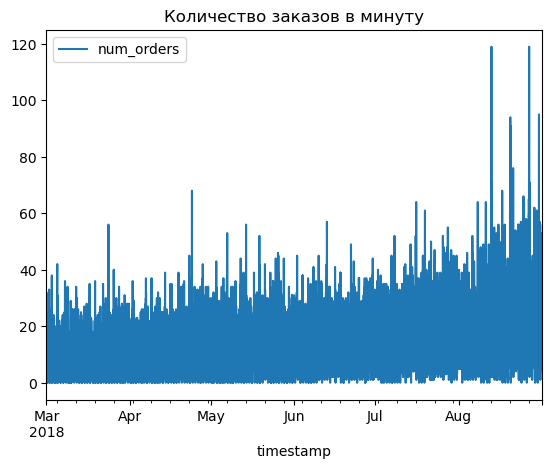

In [7]:
taxi.data.plot()
plt.title('Количество заказов в минуту')
plt.show()

Данный график не позволяет увидеть значимые детали. Можно лишь сказать, что иногда наблюдается не свойственные пиковые значение.
Чтобы исправить данную проблему, произведем resample, получим данные в более "крупном масштабе" - часовые:

In [8]:
taxi.data_resample()
taxi.data_resampled.head()

,num_orders
timestamp,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
print(f'Ресемплированные данные имеют {taxi.data_resampled.shape[0]} строк')

Ресемплированные данные имеют 4416 строк


Теперь в нашем распоряжении имеется датафрейм суммарными данными за час. Проверим его на пропуски и дубликаты:

In [10]:
taxi.check_duplicated(taxi.data_resampled)

Количество дубликатов: 4165


в данных имеются дубликаты, однако для временного ряда это нормально. Проверим пропуски:

In [11]:
taxi_ml.check_misses(taxi.data_resampled)

Пропусков в данных нет


### Вывод

1) Исходный датафрейм имеет `26496 строк` и `1 колонку`;
2) Временной период данных с `2018-03-01 00:00:00` по `2018-08-31 23:00:00`;
3) Целевой признак - `num_orders`;

Для целей анализа данные были ресемплированы в один час. В итоге новый датафрейм содержит:

1) `4416 строк`;
2) Не содержит пропусков;
3) Содержит дубликаты, которые представляют собой повторяющиеся во времени значения, в связи с чем, не требуют обработки.

## Анализ

In [12]:
print('Временной период данных с {} по {}'.format(taxi.data_resampled.index.min(),
                                                  taxi.data_resampled.index.max()))

Временной период данных с 2018-03-01 00:00:00 по 2018-08-31 23:00:00


In [13]:
taxi.data_resampled.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Минимальное количество заказов - `0`, максимальное - `462`. В среднем - `84` заказов. Ноль заказов за час выглядит не очень правдоподобно, посмотрим на значения:

In [14]:
taxi.data_resampled.loc[taxi.data_resampled['num_orders']==0]

,num_orders
timestamp,
2018-04-06 06:00:00,0


Всего одно значение. Это мог быть сбой в сервисе или случайность.
Посмотрим гистограмму распределения заказов:

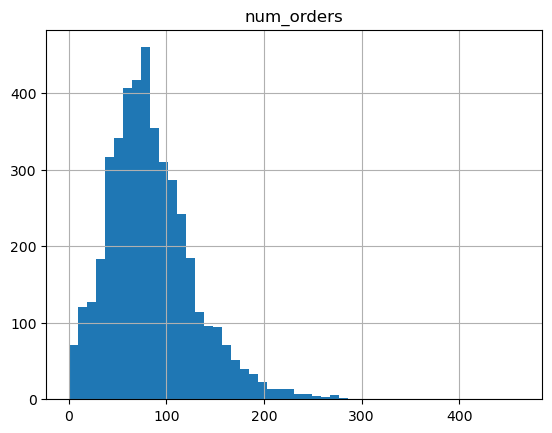

In [15]:
taxi.data_resampled.hist(bins=50)
plt.show()

Медианное значение - `78` заказов, что свидетельствует о наличии правого хвоста. Всего в `25%` случаев заказов меньше `50` и больше `107`.

Посмотрим динамику по дням:

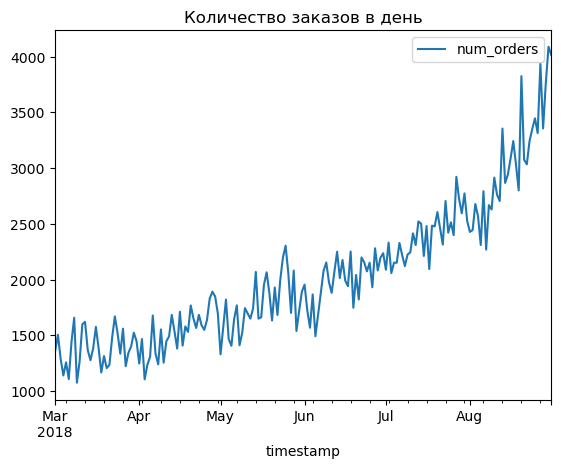

In [16]:
taxi.data_resampled.resample('1D').sum().plot() 
plt.title('Количество заказов в день')
plt.show()

Количество заказов от месяца к месяцу растет. Так, если в марте максимальное количество составляло ~1600 заказов, то к августу это значение составило ~4000 заказов. 
Это можно объяснить:
1. Сезонностью - летом заказов больше. Однако для подтверждения гипотезы нужны данные за предыдущие года;
2. Общим ростом рынка.

Посмотрим на декомпозицию:

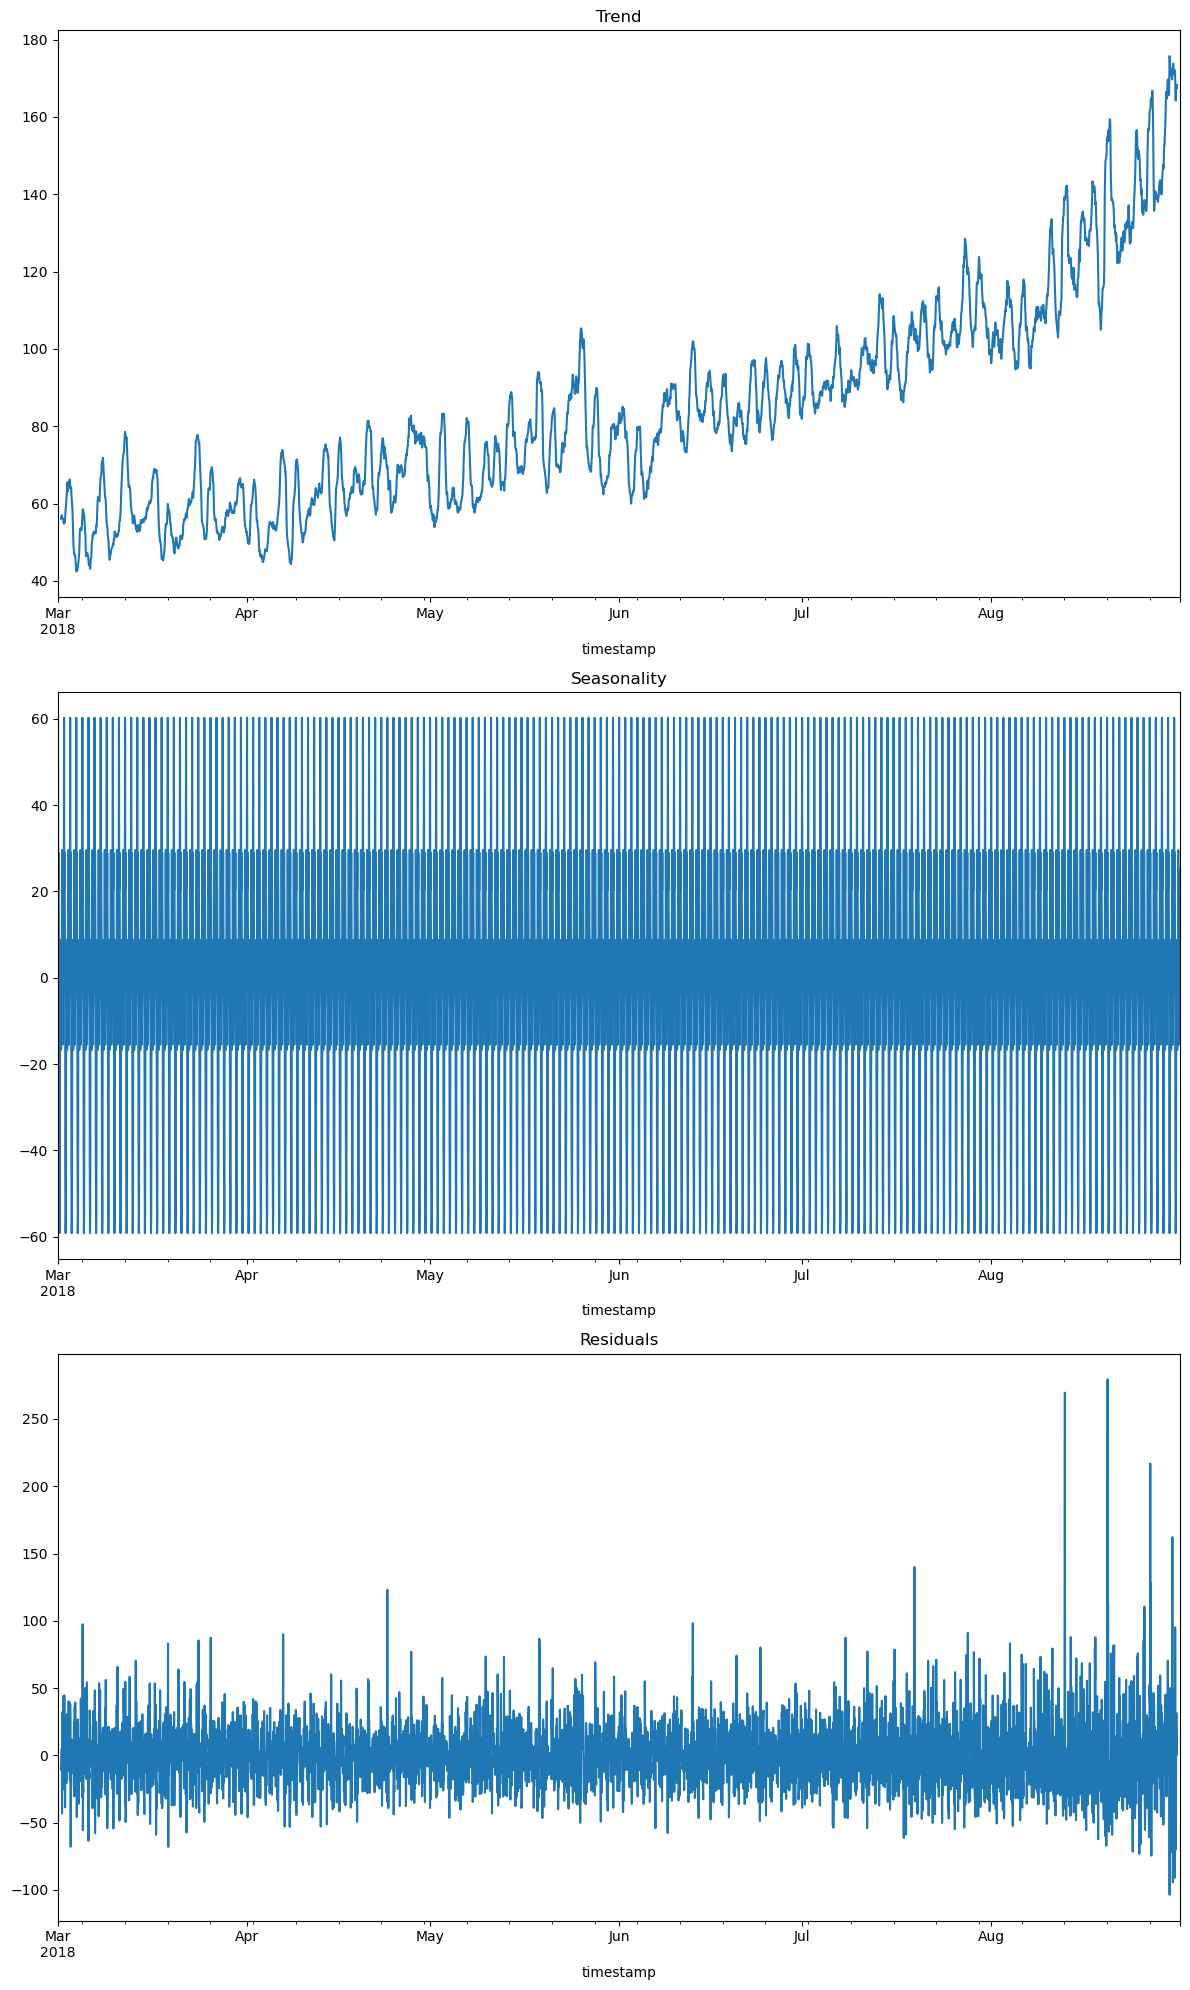

In [17]:
decomposed = seasonal_decompose(taxi.data_resampled)

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Наблюдается волатильный восходящий тренд. Однако другие особенности с таким количеством данных рассмотреть тяжело. Глянем декомпозицию за последнюю неделю данных:

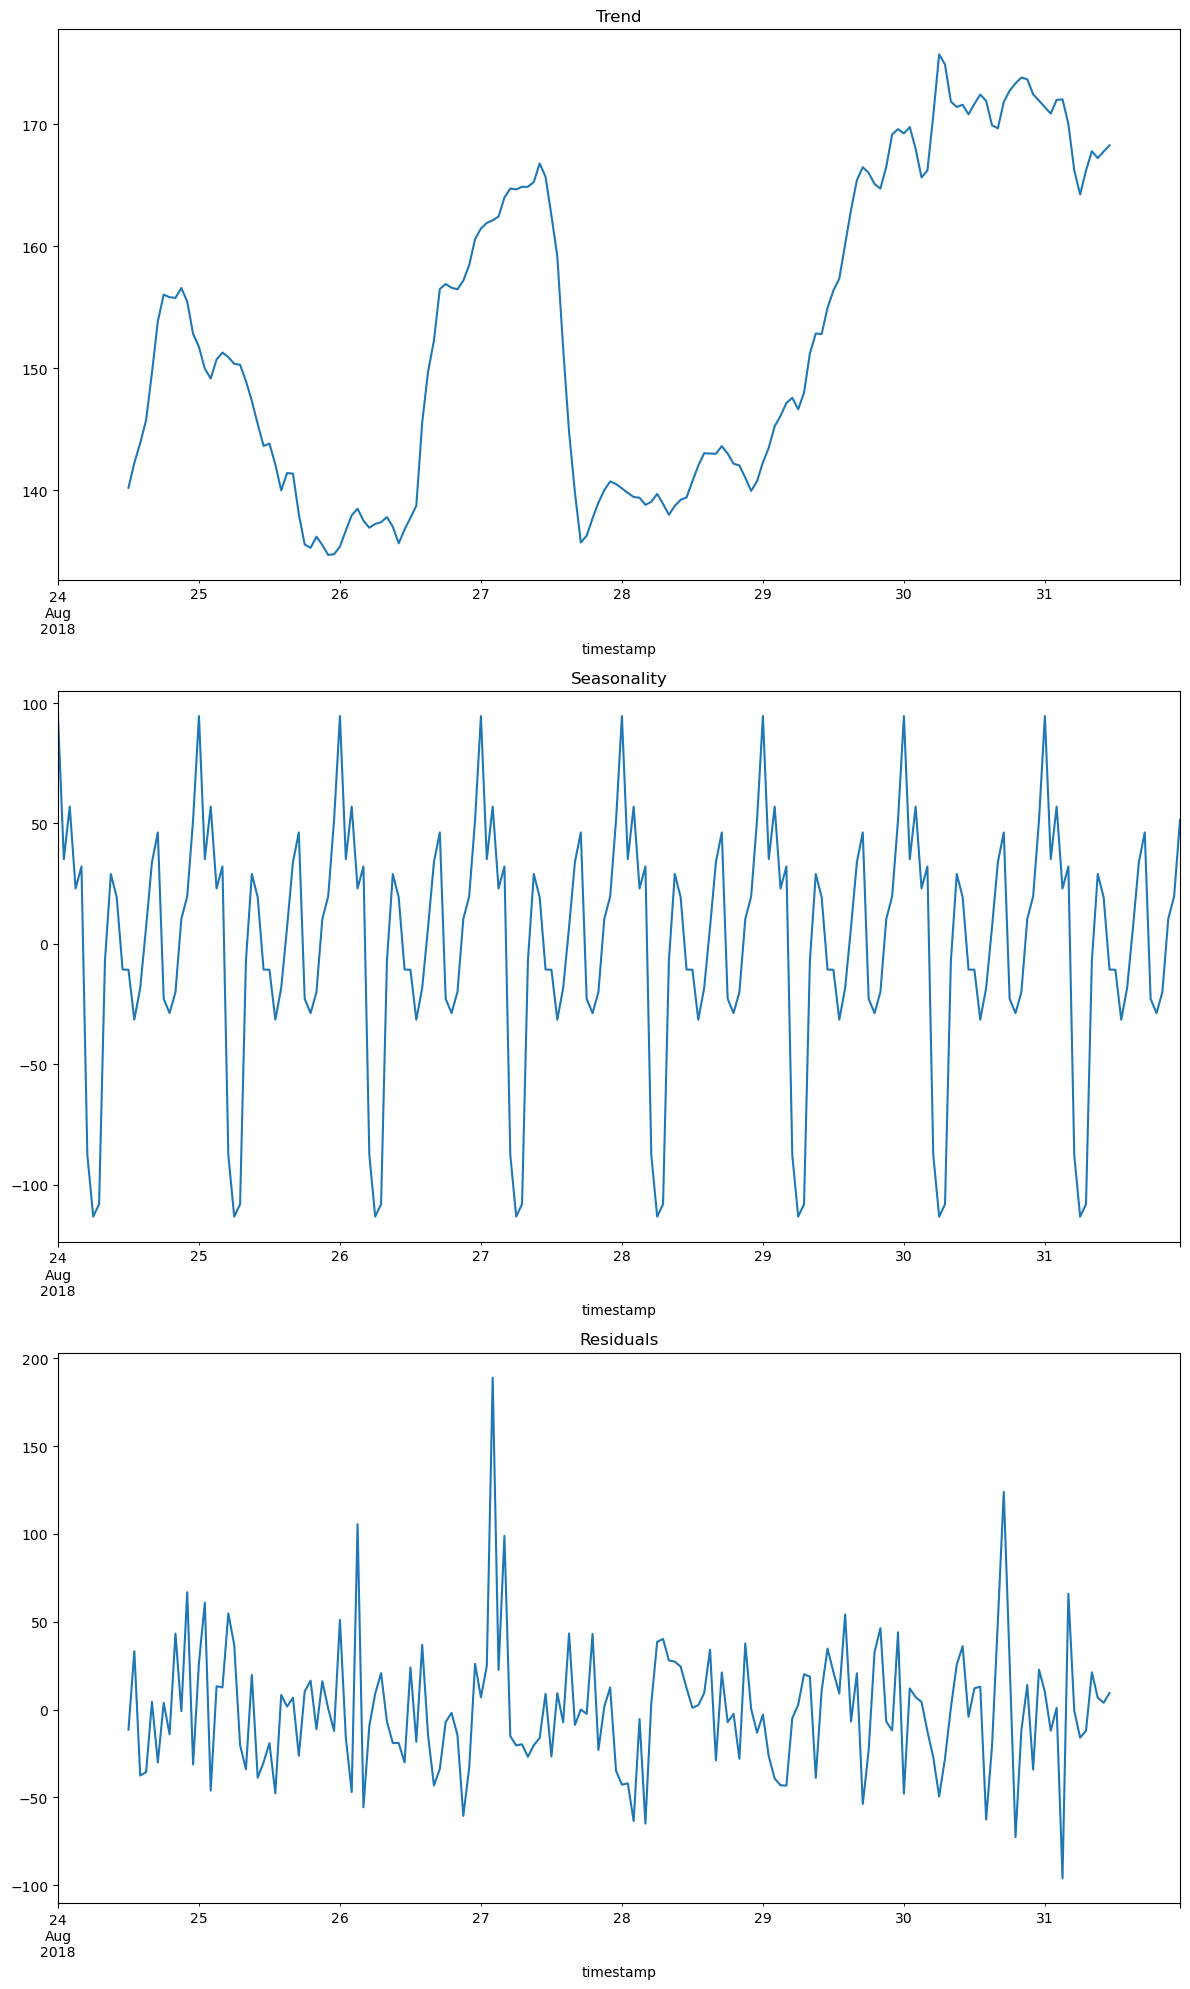

In [27]:
plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend['2018-08-24':'2018-08-31'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-08-24':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid['2018-08-24':'2018-08-31'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Здесь не видно тренда, однако видно цикличность. Так, пиковая нагрузка обычно приходится на вечер, после чего количество заказов сильно спадает. Затем начинается постепенный рост, который также заканчивается пиком вечером.

### Вывод

1. Минимальное количество заказов - `0`, максимальное - `462`. В среднем - `45` заказов;
2. Медианное значение - `78` заказов, что свидетельствует о наличии правого хвоста. Всего в `25%` случаев заказов меньше `50` и больше `107`;
3. Количество заказов от месяца к месяцу растет. Так, если в марте максимальное количество составляло ~1600 заказов, то к августу это значение составило ~4000 заказов. 
Это можно объяснить:
   1. Сезонностью - летом заказов больше. Однако для подтверждения гипотезы нужны данные за предыдущие года;
   2. Общим ростом рынка.
4. Наблюдается волатильный восходящий тренд;
5. Пиковая нагрузка обычно приходится на вечер, после чего количество заказов сильно спадает. Затем начинается постепенный рост, который также заканчивается пиком вечером.

## Обучение

Для обучения модели предпримем следующие шаги:

1) Создадим признаки. Они будут включать в себя следующие значения:
   - Значения в предыдущий период;
   - Две скользящих средних за день (период `24`) и за неделю (период `168`);
   - Посчитаем три стандартных отклонения и сделаем "триггер" пересечения. Так, например, если заказов за час больше, чем среднее значение + сигма, то значение становится равным 1, в противном случае 0.
2) Разделим выборку на признаки и целевой признак;
3) Разделим выборку на тренировочную и тестовую;
4) Обучим модель;
5) Выберем наилучшую. 

Определение признаков:

In [19]:
taxi.features_def()

Разделение на признаки и целевой признак:

In [20]:
taxi.target_features_splitter()

Количество колонок с признаком: 39.


Получаем тестовую выборку:

Обучаем модели:

In [21]:
taxi.train_test_splitter()

Размер тренировочной выборки: 3974
Размер тестовой выборки: 442


In [22]:
taxi.LGBM()

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END max_depth=7, n_estimators=50;, score=(train=-9.111, test=-23.347) total time=   0.0s
[CV 2/5] END max_depth=7, n_estimators=50;, score=(train=-10.587, test=-21.989) total time=   0.0s
[CV 3/5] END max_depth=7, n_estimators=50;, score=(train=-12.020, test=-23.805) total time=   0.0s
[CV 4/5] END max_depth=7, n_estimators=50;, score=(train=-13.401, test=-25.206) total time=   0.0s
[CV 5/5] END max_depth=7, n_estimators=50;, score=(train=-14.632, test=-30.567) total time=   0.0s
[CV 1/5] END max_depth=7, n_estimators=100;, score=(train=-5.540, test=-23.602) total time=   0.0s
[CV 2/5] END max_depth=7, n_estimators=100;, score=(train=-7.306, test=-22.028) total time=   0.1s
[CV 3/5] END max_depth=7, n_estimators=100;, score=(train=-9.386, test=-23.989) total time=   0.1s
[CV 4/5] END max_depth=7, n_estimators=100;, score=(train=-10.675, test=-25.019) total time=   0.1s
[CV 5/5] END max_depth=7, n_estimators=100;, scor

In [23]:
taxi.Catboost()

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END max_depth=7, n_estimators=50;, score=(train=-4.659, test=-23.197) total time=   0.5s
[CV 2/5] END max_depth=7, n_estimators=50;, score=(train=-6.899, test=-24.947) total time=   0.5s
[CV 3/5] END max_depth=7, n_estimators=50;, score=(train=-8.719, test=-24.801) total time=   0.4s
[CV 4/5] END max_depth=7, n_estimators=50;, score=(train=-10.754, test=-25.652) total time=   0.6s
[CV 5/5] END max_depth=7, n_estimators=50;, score=(train=-12.052, test=-32.122) total time=   0.4s
[CV 1/5] END max_depth=7, n_estimators=100;, score=(train=-3.403, test=-22.817) total time=   0.6s
[CV 2/5] END max_depth=7, n_estimators=100;, score=(train=-5.420, test=-24.152) total time=   0.9s
[CV 3/5] END max_depth=7, n_estimators=100;, score=(train=-7.475, test=-23.900) total time=   0.8s
[CV 4/5] END max_depth=7, n_estimators=100;, score=(train=-8.757, test=-24.353) total time=   0.7s
[CV 5/5] END max_depth=7, n_estimators=100;, score=(

In [24]:
taxi.DecisionTree_regressor()

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END max_depth=10;, score=(train=-8.865, test=-29.550) total time=   0.0s
[CV 2/5] END max_depth=10;, score=(train=-12.949, test=-31.303) total time=   0.0s
[CV 3/5] END max_depth=10;, score=(train=-14.719, test=-54.125) total time=   0.0s
[CV 4/5] END max_depth=10;, score=(train=-14.797, test=-35.489) total time=   0.0s
[CV 5/5] END max_depth=10;, score=(train=-16.174, test=-38.590) total time=   0.0s
[CV 1/5] END max_depth=15;, score=(train=-2.024, test=-29.814) total time=   0.0s
[CV 2/5] END max_depth=15;, score=(train=-5.710, test=-31.961) total time=   0.0s
[CV 3/5] END max_depth=15;, score=(train=-8.183, test=-55.848) total time=   0.0s
[CV 4/5] END max_depth=15;, score=(train=-6.717, test=-40.154) total time=   0.0s
[CV 5/5] END max_depth=15;, score=(train=-8.133, test=-46.004) total time=   0.0s
[CV 1/5] END max_depth=25;, score=(train=-0.000, test=-30.716) total time=   0.0s
[CV 2/5] END max_depth=25;, score=

## Тестирование

Посмотрим на результаты обучения:

In [25]:
results = {
    'model' : 
        [*taxi.models_dict.keys()],
    'score' : 
        [taxi.models_dict[value]['score'] 
         for value in taxi.models_dict.keys()],
    'time' : 
        [taxi.models_dict[value]['time'] 
         for value in taxi.models_dict.keys()],
    }
display(pd.DataFrame(results))

,model,score,time
0,LGBM,24.982822,2.926134
1,Catboost,25.368902,40.263803
2,DecisionTree,37.811374,0.601806


Наилучшая модель `LGBM` с результатом в ошибки `rmse`  `24.98`. На втором месте с небольшим отставанием - `Catboost` с результатом `25.36`. 
Протестируем модель на тестовой выборке:

In [26]:
pred = taxi.LGBM_result.predict(taxi.features_test)
mean_squared_error(taxi.target_test,pred, squared=False)

41.86305377200003

Таким образом, итоговый результат rmse для модели `LGBM` составляет `41.86` на тестовой выборке. Данная модель подходит по критерии заказчика.

## Вывод

а. Подготовка

1) Исходный датафрейм имеет `26496 строк` и `1 колонку`;
2) Временной период данных с `2018-03-01 00:00:00` по `2018-08-31 23:00:00`;
3) Целевой признак - `num_orders`;

Для целей анализа данные были ресемплированы в один час. В итоге новый датафрейм содержит:

1) `4416 строк`;
2) Не содержит пропусков;
3) Содержит дубликаты, которые представляют собой повторяющиеся во времени значения, в связи с чем, не требуют обработки.

b. Анализ данных

1. Минимальное количество заказов - `0`, максимальное - `462`. В среднем - `45` заказов;
2. Медианное значение - `78` заказов, что свидетельствует о наличии правого хвоста. Всего в `25%` случаев заказов меньше `50` и больше `107`;
3. Количество заказов от месяца к месяцу растет. Так, если в марте максимальное количество составляло ~1600 заказов, то к августу это значение составило ~4000 заказов. 
Это можно объяснить:
   1. Сезонностью - летом заказов больше. Однако для подтверждения гипотезы нужны данные за предыдущие года;
   2. Общим ростом рынка.
4. Наблюдается волатильный восходящий тренд;
5. Пиковая нагрузка обычно приходится на вечер, после чего количество заказов сильно спадает. Затем начинается постепенный рост, который также заканчивается пиком вечером.

с. Обучение модели

Для обучения модели были сделаны следующие шаги:

1) Созданы признаки, которые включали в себя следующие значения:
   - Значения в предыдущий период;
   - Две скользящих средних за день (период `24`) и за неделю (период `168`);
   - Посчитаем три стандартных отклонения и сделаем "триггер" пересечения. Так, например, если заказов за час больше, чем среднее значение + сигма, то значение становится равным 1, в противном случае 0.
2) Разделили выборку на признаки и целевой признак;
3) Разделили выборку на тренировочную и тестовую;
4) Обучили модель;
5) Выбрали лучшую модель - `LGBM` с итоговым результатом ошибки `RMSE` - `41.86`.